## Assignment: Image recognition
- Student 1: Víctor Morcuende Castell
- Student 2: Guillermo Nájera Lavid

The goals of the assignment are:

- Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
- Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem (28th Feb - 7th Mar).
- Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task (7th Mar - 14th Mar).
- Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning (14th Mar - 23rd Mar)

Follow the link below to download the classification data set “xview_recognition”: https://drive.upm.es/s/UeDNT7JEYFkCVPP

In [1]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [2]:
categories = {0: 'CARGO_PLANE', 1: 'HELICOPTER', 2: 'SMALL_CAR', 3: 'BUS', 4: 'TRUCK', 5: 'MOTORBOAT', 6: 'FISHING_VESSEL', 7: 'DUMP_TRUCK', 8: 'EXCAVATOR', 9: 'BUILDING', 10: 'STORAGE_TANK', 11: 'SHIPPING_CONTAINER'}

In [3]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, do_shuffle=False, augmentation=None):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                img = load_geoimage(filename)
                if augmentation:
                    # Apply data augmentation
                    img = augmentation.random_transform(img)
                images.append(img)
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

#### Training

In [5]:
import json

# Load database
json_file = '/Users/victor/Documents/GitHub/DL_1/xview_recognition/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [6]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage('/Users/victor/Documents/GitHub/DL_1/xview_recognition/' + json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'CARGO_PLANE': 635, 'HELICOPTER': 70, 'SMALL_CAR': 11675, 'BUS': 4017, 'TRUCK': 5836, 'MOTORBOAT': 571, 'FISHING_VESSEL': 457, 'DUMP_TRUCK': 1108, 'EXCAVATOR': 741, 'BUILDING': 13011, 'STORAGE_TANK': 1249, 'SHIPPING_CONTAINER': 816}


In [7]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)

In [8]:
# Load architecture
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1_l2

input_shape = (224, 224, 3)

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape, pooling=max)

x = base_model.output
x = Dropout(0.4)(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(len(categories), kernel_regularizer=l1_l2(0.001), bias_regularizer=l1_l2(0.001), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Metal device set to: Apple M2 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-04-16 19:59:27.372692: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-16 19:59:27.373080: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [9]:
from keras.optimizers import Adam

# Learning rate is changed to 0.001
opt = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.01, amsgrad=False, clipnorm=1.0, clipvalue=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [10]:
from keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_categorical_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_categorical_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_categorical_accuracy', patience=30, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [11]:
from keras.preprocessing.image import ImageDataGenerator

# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]

batch_size = 128

# Define data augmentation parameters
augmentation = ImageDataGenerator(rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = generator_images(objs_train, batch_size, do_shuffle=True, augmentation=augmentation)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False, augmentation=None)

In [12]:
import math
import numpy as np
print('Training model')
epochs = 30
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_categorical_accuracy']))
best_value = np.max(h.history['val_categorical_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_categorical_accuracy ' + str(best_value))

Training model
Epoch 1/30


2023-04-16 19:59:30.047843: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-16 19:59:34.986620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


283/283 [==============================] - ETA: 0s - loss: 1.0334 - categorical_accuracy: 0.7753

2023-04-16 20:04:36.149309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_categorical_accuracy improved from -inf to 0.81737, saving model to model.hdf5
283/283 [==============================] - 320s 1s/step - loss: 1.0334 - categorical_accuracy: 0.7753 - val_loss: 0.7181 - val_categorical_accuracy: 0.8174 - lr: 0.0010
Epoch 2/30
283/283 [==============================] - ETA: 0s - loss: 0.6268 - categorical_accuracy: 0.8358
Epoch 2: val_categorical_accuracy improved from 0.81737 to 0.84648, saving model to model.hdf5
283/283 [==============================] - 274s 967ms/step - loss: 0.6268 - categorical_accuracy: 0.8358 - val_loss: 0.5722 - val_categorical_accuracy: 0.8465 - lr: 0.0010
Epoch 3/30
283/283 [==============================] - ETA: 0s - loss: 0.5438 - categorical_accuracy: 0.8514
Epoch 3: val_categorical_accuracy improved from 0.84648 to 0.85544, saving model to model.hdf5
283/283 [==============================] - 273s 964ms/step - loss: 0.5438 - categorical_accuracy: 0.8514 - val_loss: 0.5292 - val_categorical_accuracy: 0.8554 -

#### Testing

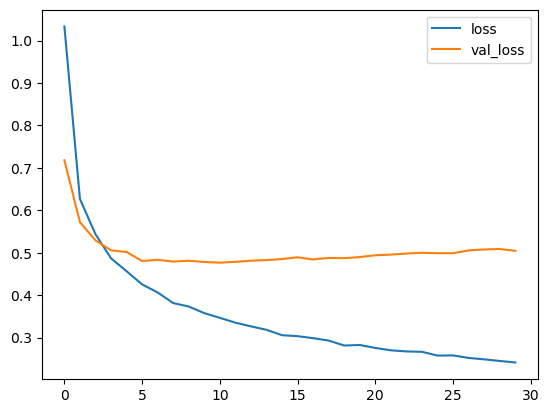

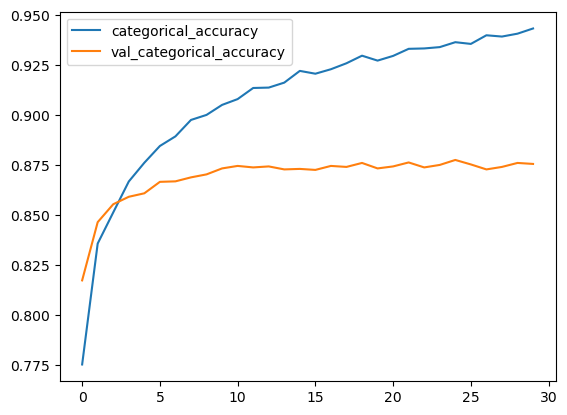

In [13]:
import matplotlib.pyplot as plt

metrics = h.history
plt.plot(h.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()
plt.plot(h.epoch, metrics['categorical_accuracy'], metrics['val_categorical_accuracy'])
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'])
plt.show()

In [14]:
import json

# Load database
json_file = '/Users/victor/Documents/GitHub/DL_1/xview_recognition/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [15]:
import numpy as np

anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage('/Users/victor/Documents/GitHub/DL_1/xview_recognition/' + json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    image.add_object(obj)
    anns.append(image)

In [16]:
import numpy as np

# model.load_weights('model.hdf5', by_name=True)
y_true, y_pred = [], []
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

2023-04-16 22:17:21.622282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 27ms/step


/var/folders/5b/pst1p37n3d3_7g1ndtrt8n840000gn/T/ipykernel_14733/956665539.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


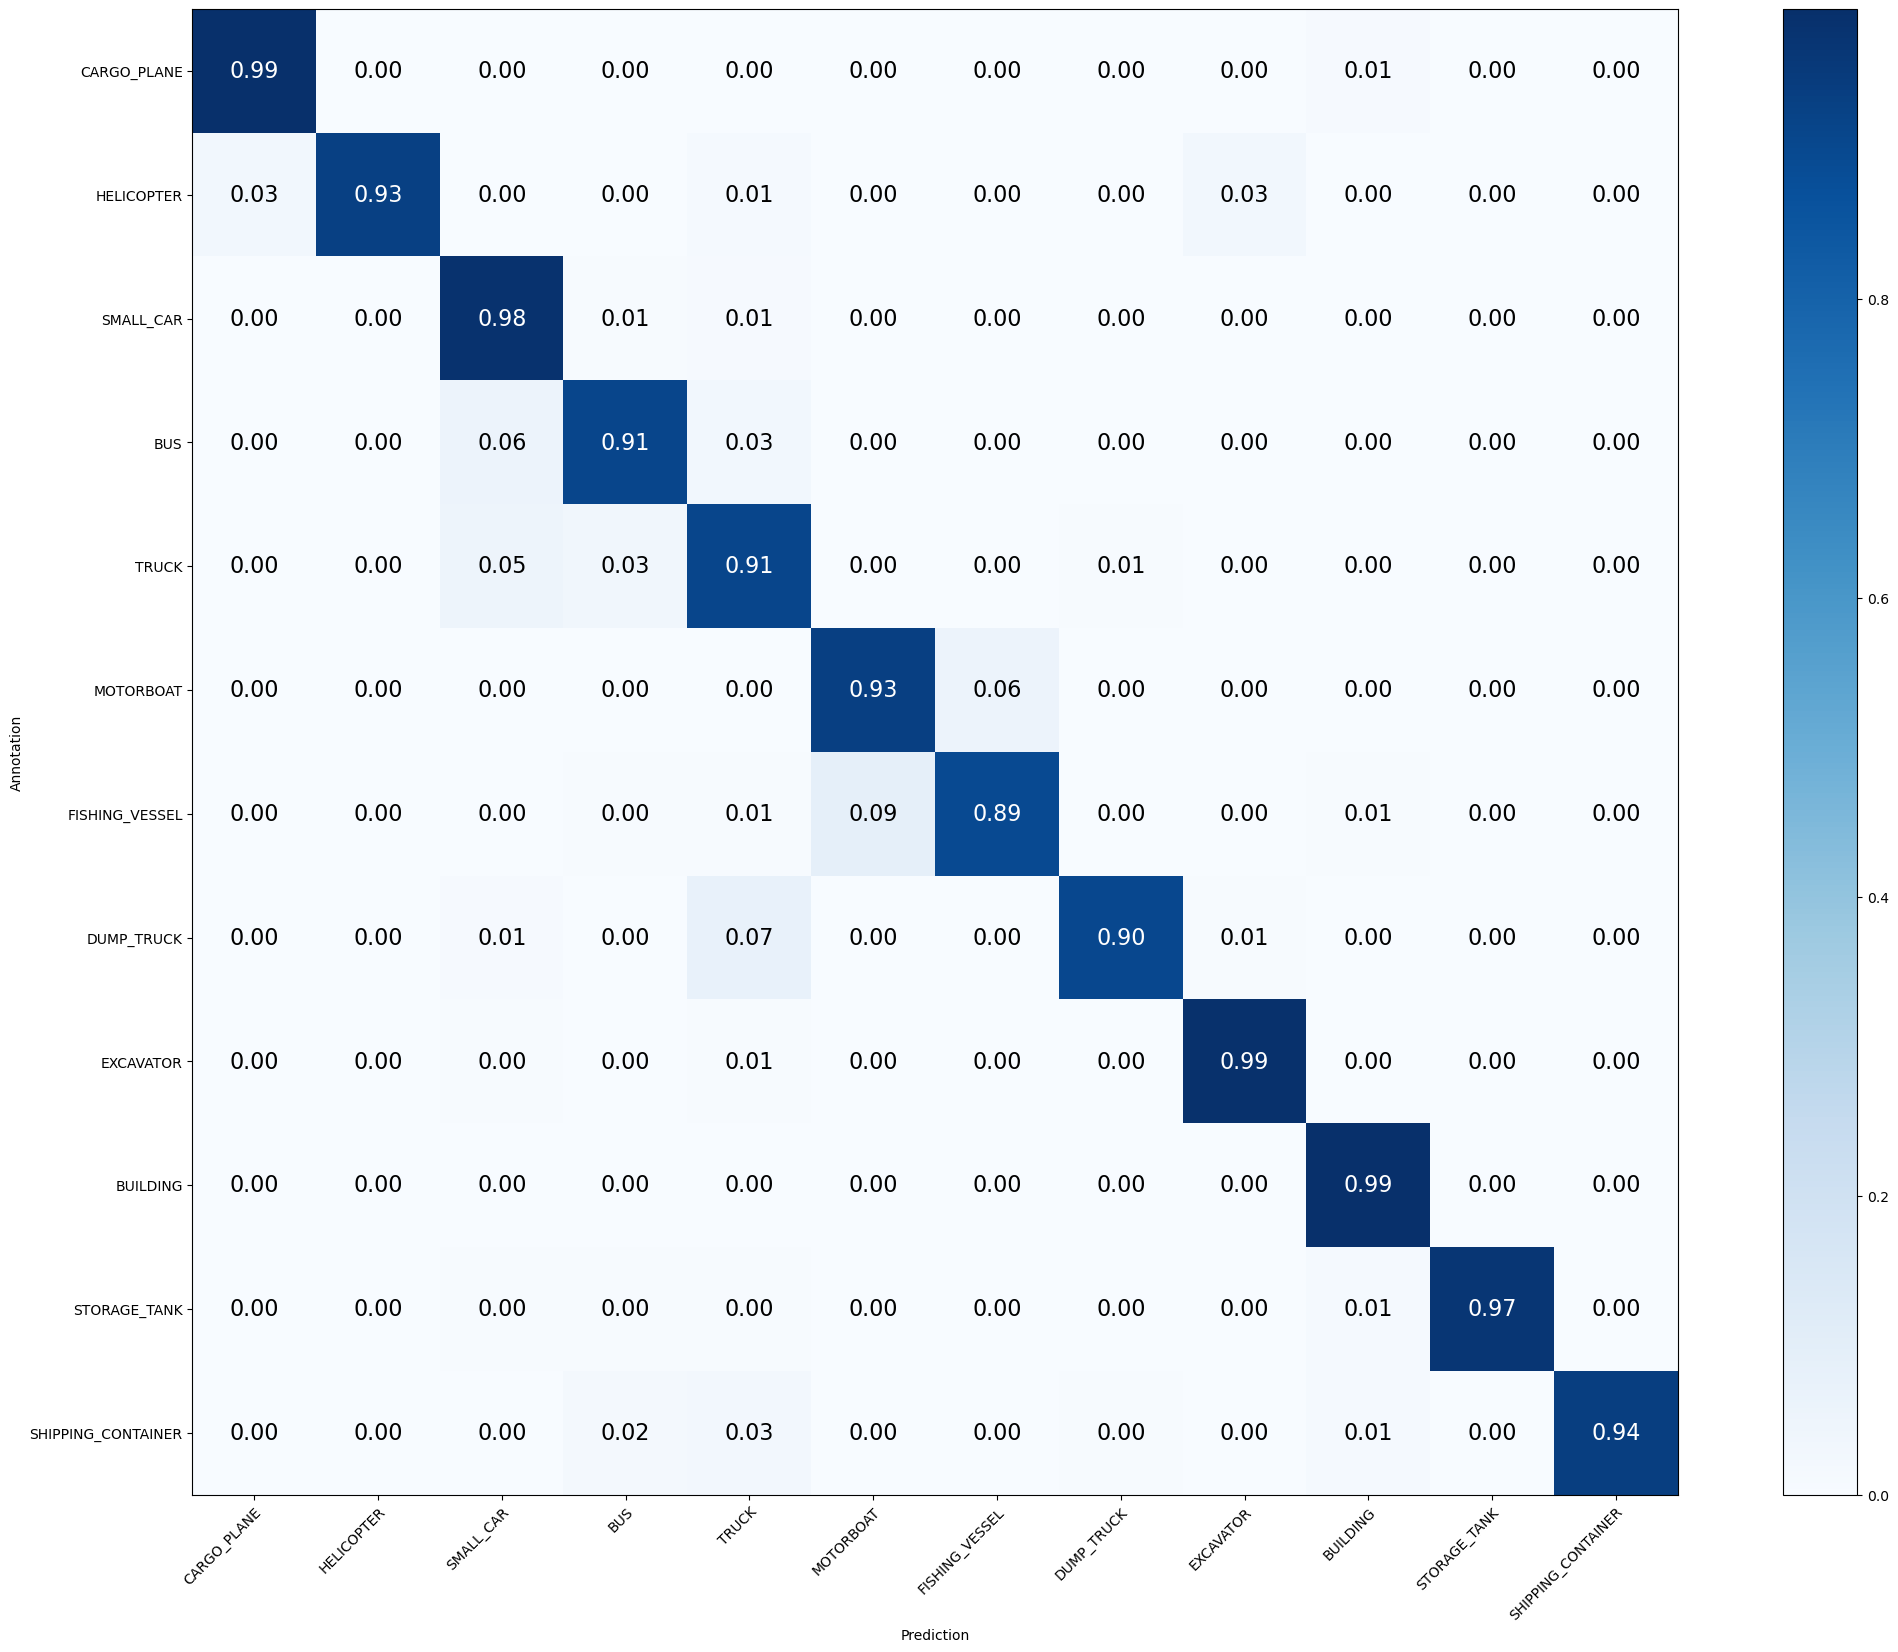

In [17]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [18]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 96.342%
Mean Recall: 94.530%
Mean Precision: 96.220%
> CARGO_PLANE: Recall: 99.213% Precision: 98.746% Specificity: 99.980% Dice: 98.979%
> HELICOPTER: Recall: 92.857% Precision: 100.000% Specificity: 100.000% Dice: 96.296%
> SMALL_CAR: Recall: 98.296% Precision: 95.442% Specificity: 98.078% Dice: 96.848%
> BUS: Recall: 90.988% Precision: 92.345% Specificity: 99.162% Dice: 91.661%
> TRUCK: Recall: 90.987% Precision: 93.486% Specificity: 98.923% Dice: 92.220%
> MOTORBOAT: Recall: 93.345% Precision: 92.215% Specificity: 99.886% Dice: 92.776%
> FISHING_VESSEL: Recall: 89.497% Precision: 92.325% Specificity: 99.914% Dice: 90.889%
> DUMP_TRUCK: Recall: 90.433% Precision: 95.520% Specificity: 99.880% Dice: 92.907%
> EXCAVATOR: Recall: 98.785% Precision: 98.387% Specificity: 99.970% Dice: 98.586%
> BUILDING: Recall: 99.370% Precision: 99.423% Specificity: 99.724% Dice: 99.397%
> STORAGE_TANK: Recall: 96.958% Precision: 99.425% Specificity: 99.982% Dice: 98.176%
> SHIPPING_CONTA